                             #Fotoğraflardaki El Yazı Tanıma Projesi (Handwriting Recognition Project in Photographs) 

# Burada önce el yazısı ile yazılan rakamların fotoğraflarınnı sisteme yükleyip her bir rakam için sistemimizi eğiteceğiz. Daha sonra sisteme el yazısı ile yazılan yeni bir rakamı tanımasını isteyeceğiz.        


# Here we will first upload photos of handwritten numbers to the system and train our system for each number. Then we will ask the system to recognize a new handwritten number.


# Projemizdeki kullanacağımız MNIST elyazısı veri tabanında (sklearn içinde gelmektedir) 784 feature (özellik) sütunu mavcut(784 dimensions), ve training set olarak 60,000 örnek veri ve a 10,000 örneklik test seti bulunmaktadır.



# The MNIST handwriting database (included in sklearn) that we will use in our project has 784 feature columns (784 dimensions), 60,000 sample data as a training set and a 10,000 sample test set.


In [7]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml # mnist datasetini yüklemek için gerekli
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# Bu işlem 1-2 dk sürebilir. (This process may take 1-2 minutes.)

mnist = fetch_openml("mnist_784")

In [8]:
mnist.data.shape      # Kaç tane kayıt olduğunu gösterir. 70.000 kayıt var. 784 feature(özellik, sütun) var. 
                      # Shows how many records there are. There are 70,000 records. There are 784 features.

(70000, 784)

# MNIST veri seti, el yazısı rakamlarını (0-9) içeren ve genellikle çeşitli görüntü işleme sistemlerini eğitmek için kullanılan bir veridir. `mnist.data` dizisinin şekli genellikle kullandığınız kütüphaneye bağlı olarak şöyle olur:

# - **Eğitim seti:** `(60000, 784)`
# - **Test seti:** `(10000, 784)`

# Burada `60000`, eğitim örneği sayısını; `10000`, test örneği sayısını; `784` ise her bir 28x28 görüntüdeki piksel sayısını temsil eder (28 * 28 = 784). Veriyi yeniden şekillendirdiğinizde, `(60000, 28, 28)` olarak görüntülere dönüştürebilirsiniz.



# The MNIST dataset is a dataset that contains handwritten digits (0-9) and is commonly used to train various image processing systems. The format of the `mnist.data` array is usually as follows, depending on the library you use:

# - **Training set:** `(60000, 784)`
# - **Test set:** `(10000, 784)`

# Here `60000` represents the number of training samples; `10000` represents the number of test samples; `784` represents the number of pixels in each 28x28 image (28 * 28 = 784). When you reshape the data, you can convert it into images as `(60000, 28, 28)`.

In [10]:
# mnist veriseti içindeki rakam fotoğraflarını görmek için bir fonksiyon tanıyalım:

# Let's introduce a function to see the digit images in the mnist dataset:

In [11]:
# Parametre olarak dataframe ve ilgili veri fotoğrafını index numarasını alsın...
# Take the index number of the dataframe and the related data photo as parameters...

def showimage(dframe, index):
    some_digit = dframe.to_numpy()[index]
    some_digit_image = some_digit.reshape(28,28)

    plt.imshow(some_digit_image,cmap="binary")
    plt.axis ("off")
    plt.show()

# `plt.imshow(some_digit_image, cmap="binary")` kullanarak bir el yazısı rakam görüntüsünü siyah-beyaz (binary) renk paletiyle görselleştirirsiniz. Bu kod, `some_digit_image` değişkenindeki görüntüyü gösterir ve piksel değerlerini siyah (0) ve beyaz (1) olarak ayırır. Görüntü, el yazısı rakamlarının daha iyi anlaşılmasını sağlar. 


# Using `plt.imshow(some_digit_image, cmap="binary")` you visualize a handwritten digit image with a black and white (binary) color palette. This code displays the image in the `some_digit_image` variable and separates the pixel values ​​into black (0) and white (1). The image provides a better understanding of the handwritten digits.

In [13]:
# örnek kullanım:   (# example usage:)

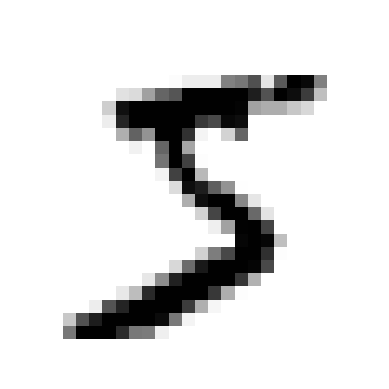

In [14]:
showimage(mnist.data, 0)   # ilk veri seti 0. indextir ve bu kod ilk veri setini gösteriyor. 
                           # first data set is index 0 and this code shows the first data set.

# Split Data => Training Set ve Test Set


# Veri setini eğitim ve test setlerine ayırmak için genellikle train_test_split fonksiyonu kullanılır. Bu işlem, modelin doğruluğunu değerlendirmek için önemlidir.

# The train_test_split function is usually used to split the dataset into training and test sets. This process is important for evaluating the accuracy of the model.

In [16]:
# test ve train oranı 1/7 ve 6/7

train_img, test_img, train_1b1, test_1b1 = train_test_split(mnist.data, mnist.target, test_size=1/7.0, random_state=0)

# Bu kod, MNIST veri setini eğitim ve test setlerine ayırır. train_test_split fonksiyonu, mnist.data ve mnist.target'ı kullanarak görüntü verilerini ve etiketleri böler. test_size=1/7.0 ile verilerin yaklaşık %14'ü test setine ayrılır. random_state=0 ise sonuçların tekrarlanabilirliğini sağlar. Sonuç olarak, train_img ve test_img eğitim ve test görüntülerini; train_1b1 ve test_1b1 ise ilgili etiketleri içerir.


# This code splits the MNIST dataset into training and test sets. The train_test_split function splits the image data and labels using mnist.data and mnist.target. With test_size=1/7.0, approximately 14% of the data is allocated to the test set. Random_state=0 ensures repeatability of the results. As a result, train_img and test_img contain the training and test images, and train_1b1 and test_1b1 contain the corresponding labels.

In [18]:
type(train_img)

pandas.core.frame.DataFrame

In [19]:
# Rakam tahminlerimizi check etmek için train-img dataframeini kopyalıyoruz, çünkü az sonra değişecek.

# We copy the train-img dataframe to check our number predictions, because it will change soon.

test_img_copy = test_img.copy()

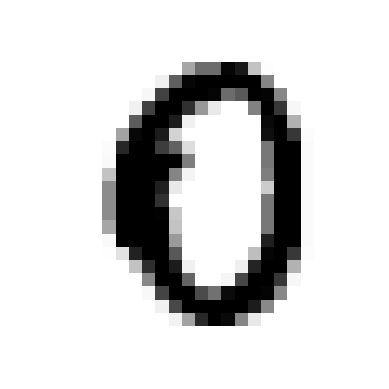

In [20]:
showimage(test_img_copy,0)

# Verileri Scale etmemiz gerekiyor:  (# We need to scale the data:)


# Çünkü PCA scale edilmemiş verilerde hatalı sonuçlar verebiliyor bu nedenle mutlaka scalling işleminden geçiriyoruz. Bu amaçla da StandardScaler kullanıyoruz.

# Because PCA can give incorrect results on unscaled data, we always apply scaling. For this purpose, we use StandardScaler.

In [22]:
scaler = StandardScaler()

# scaler'ı sadece Training set üzerinde fit yapmamız yeterli... (# We only need to fit the scaler on the Training set...)

scaler.fit(train_img)

# Ama transform işlemini hem training sete hem de test sete yapmamız gerekiyor...

# But we need to do the transform operation on both the training set and the test set...

train_img = scaler.transform(train_img)
test_img = scaler.transform(test_img)

In [23]:
# PCA yapmak için scaler yaptık. (# We made a scaler to perform PCA.)

In [24]:
# PCA işlemini uyguluyoruz. (# We apply the PCA process.)

In [25]:
# Variance'in %95 oranında korunmasını istediğimizi belirtiyoruz.  (# We state that we want the variance to be preserved at 95%.)

# modelin bir örneğini yapmak (make an instance of the model)

In [46]:
pca = PCA(.95)

In [50]:
# PCA'i sadece training sete yapmamız yeterli: (1 dk sürebilir)   (# We only need to do PCA on the training set: (It may take 1 min))
pca.fit(train_img)

PCA(n_components=0.95)

In [54]:
# bakalım 784 boyutu kaç boyuta düşürebilmiş (½95 variance'ı koruyarak tabiki)
# Let's see how many dimensions 784 was able to reduce (keeping the ½95 variance of course)
print(pca.n_components_)

327


In [56]:
# Şimdi transform işlemiyle hem train hem de test veri setimizin boyutlarını 784'ten 327'ye düşürelim:
# Now let's reduce the size of both our train and test data sets from 784 to 327 with the transform operation:
train_img = pca.transform(train_img)
test_img = pca.transform(test_img)

# 2. Aşama  (# Phase 2)

In [67]:
# Şimdi Makine Öğrenmesi modelimiz olan Logistic Regression modelimizi PCA işleminden geçirilmiş veri setimiz üzerinde uygulayacağız.
# Now we will apply our Machine Learning model, Logistic Regression model, on our PCA processed data set.


# Default solver çok yavaş çalıştığı için daha hızlı olan "lbfgs" solveri seçerek Logisticregression  nesnemizi oluşturuoruz.
# Since the default solver works very slowly, we create our Logisticregression object by choosing the faster "1bfgs" solver.

logisticRegr = LogisticRegression(solver = "lbfgs", max_iter=10000)

# LogisticRegression Modelimizi train datamızı kullanarak eğitiyoruz.:
# We train our LogisticRegression Model using our train data:

In [74]:
# (birkaç dk sürebilir) # (may take a few minutes)
logisticRegr.fit(train_img, train_1b1)

LogisticRegression(max_iter=10000)

In [76]:
# Modelimiz eğitildi şimdi el yazısı rakamları makine öğrenmesi ile tanıma işlemini gerçekleştirelim.
# Our model is trained, now let's recognize handwritten numbers using machine learning.

logisticRegr.predict(test_img[0].reshape(1,-1))

array(['0'], dtype=object)

# logisticRegr.predict(test_img[0].reshape(1, -1)) ifadesi, bir makine öğrenimi modelinin (logistik regresyon) bir test görüntüsünü (veya veri örneğini) tahmin etmek için kullanılır. Burada, test_img dizisindeki ilk görüntü (yani test_img[0]) alınır ve modelin beklediği formatta (2 boyutlu bir dizi) yeniden şekillendirilir.

# Açıklama:
# test_img[0]: test_img dizisindeki ilk görüntüyü alır. Bu genellikle bir numpy dizisi şeklindedir.
# .reshape(1, -1): Bu, görüntüyü 2 boyutlu bir dizi haline getirir. 1 satır ve -1 sütun demektir; bu, sütun sayısının otomatik olarak ayarlanmasını sağlar. Yani tek bir örnek için tüm piksel verileri bir vektör haline getirilir.
# logisticRegr.predict(...): Bu, logisticRegr modelinin predict metodunu çağırır ve verilen verinin hangi sınıfa ait olduğunu tahmin eder.


# The statement logisticRegr.predict(test_img[0].reshape(1, -1)) is used to predict a test image (or data sample) of a machine learning model (logistic regression). Here, the first image in the test_img array (i.e. test_img[0]) is taken and reshaped into the format expected by the model (a 2D array).

# Explanation:
# test_img[0]: Takes the first image in the test_img array. This is usually a numpy array.
# .reshape(1, -1): This converts the image into a 2D array. This means 1 row and -1 column, which automatically adjusts the number of columns. So all the pixel data for a single sample is converted into a vector.
# logisticRegr.predict(...): This calls the predict method of the logisticRegr model and predicts which class the given data belongs to.

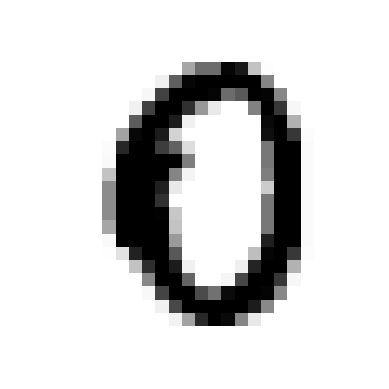

In [83]:
showimage(test_img_copy, 0)          # ilk veri # First data

In [86]:
logisticRegr.predict(test_img[2].reshape(1,-1))

array(['1'], dtype=object)

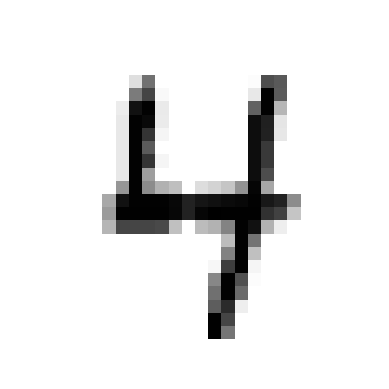

In [88]:
showimage(test_img_copy,1)

# Eldeki fotoğrafların doğruluğunu kanıtlamak için tek tek bakmıyoruz. Bunun için score metodunu kullanıyoruz.
# We do not look at the photos one by one to prove their accuracy. We use the score method for this.


# Modelimizin doğruluk oranı (aacuracy) ölçmek için score metodunu kullanacağız.
# We will use the score method to measure the accuracy of our model.

In [91]:
logisticRegr.score(test_img,test_1b1)

0.9187

In [93]:
# Bu projede PCA algoritmasını kullandık.

# Bu projede PCA kullanarak logistic regression tarafından yapay zekanın eğitilme süresini önemli ölçüde kısalttık. Ben %95 variance korumayı hedefledim. Siz %95 Variance'i daha düşük seviyelere çekerek sürenin ne lçüde kısaldığını kendiniz deneyerek bulabilirsiniz. 10 tane digit için yapay zekanın eğitim süresini çok büyük ölçüde kısaltan PCA algoritması yüzlerce hatta binlerce değişik nesne tipi için yapay zekanın eğitim süresini saatler mertebesinde kısaltacak ve bu sizin programlarınızı çok daha hızlı çalışmasını sağlayacaktır.

# Bu proje ile birbirinden tamamen farklı 2 makine öğrenme modelini bir araya getirip günlük hayatta karşımıza çıkabilecek bir işi bilgisayarımıza yapay zeka programı yazarak gerçekleştirdik. 




# In this project, we significantly shortened the training time of the AI ​​by using PCA and logistic regression. I aimed to maintain 95% variance. You can find out how much time is shortened by lowering the 95% variance by trying it yourself. The PCA algorithm, which greatly shortens the training time of the AI ​​for 10 digits, will shorten the training time of the AI ​​for hundreds or even thousands of different object types by hours, and this will allow your programs to work much faster.

# With this project, we combined 2 completely different machine learning models and completed a task that we can encounter in daily life by writing an AI program on our computer.